# M5 Competiotn - Data Understanding

## Decrizione del dataset:
Il dataset comprende vendite di unità di vari prodotti venduti negli USA, organizzati nella forma di serie raggruppate. 

Nello specifico, il dataset comprende vendite di unità di ****3075**** prodotti, classificati in 3 categorie di prodotto ****(Hobbies, Foods, Household)**** e ****7 dipartimenti**** di prodotto, in cui le 3 categorie sopra-menzionate sono disaggregate. I prodotti sono venduti tra ****10**** negozi, localizzati in ****3**** Sati (California ****CA****, Texas ****TX****, e Wisconsin ****WI****)

### M5 Competition  - DataSet 
Il diagramma in basso mostra la struttura gerarchica dei dati.
* 3 Stati (CA,TX,WI)
* 10 Negozi (CA1,CA2...,WI2,WI3)
* 3 categorie (Hobbies, Foods, Household)
* 7 dipartimenti di prodotto (in cui le 3 categorie sopra-menzionate sono disaggregate)
* 3049 unique items 


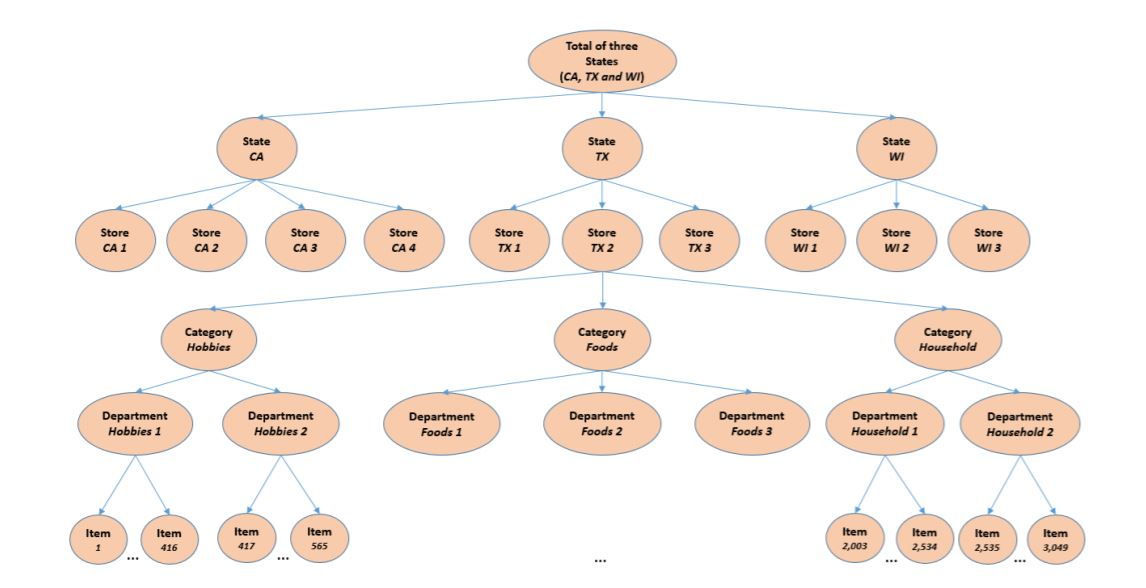

In [80]:
from IPython.display import Image
Image("../input/images/M5graph.JPG")

In [81]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import random 
from itertools import cycle
from ipywidgets import widgets, interactive
from tqdm.autonotebook import tqdm
import datetime
import seaborn as sns


tqdm.pandas()
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
 

# Descrizione dei file
- `calendar.csv` - contiene informazioni sulle date in cui i prodotti sono venduti
- `sales_train_validation.csv` - contiene i dati storici sulle vendite giornaliere unitarie per prodotto e negozio [d_1 - d_1913]
- `sell_prices.csv` - contiene informazioni sul prezzo dei prodotti venduti per negozio e data.
- `sample_submission.csv` - il formato corretto per le sottomissioni.

Non ancora disponibili:
- `sales_train_evaluation.csv` - Disponibile un mese prima della deadline della competizione e comprenderà le vendite dal [d_1 - d_1941]

### File 1: “calendar.csv” 

Il file ha quindi ****1969**** righe, corrispondenti ai giorni di vendite dal ****29 Gennaio 2011 al 19 Giugno 2016**** ( compresi dei 28 da prevedere) e 14 colonne indicanti:

* date: The date in a “y-m-d” format.
* wm_yr_wk: The id of the week the date belongs to.
* weekday: The type of the day (Saturday, Sunday, …, Friday).
* wday: The id of the weekday, starting from Saturday.
* month: The month of the date.
* year: The year of the date.
* event_name_1: If the date includes an event, the name of this event.
* event_type_1: If the date includes an event, the type of this event.
* event_name_2: If the date includes a second event, the name of this event.
* event_type_2: If the date includes a second event, the type of this event.
* snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed.


In [82]:
df_calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [83]:
df_calendar.shape

(1969, 14)

### File 2: “sell_prices.csv”
Contiene informazioni sul prezzo dei prodotti venduti per negozio e data:

* store_id: The id of the store where the product is sold. 
* item_id: The id of the product.
* wm_yr_wk: The id of the week.
* sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  


In [84]:
df_sell_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
df_sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [85]:
df_sell_prices.shape

(6841121, 4)

In [86]:
print ("Tehere are:", len(df_sell_prices['item_id'].unique()) , "unique items")
print ("Tehere are:", len(df_sell_prices['store_id'].unique()) , "unique stores")
print ("maximuim all items price is :",max(df_sell_prices['sell_price']),"$")
print ("minimum all items price is :",min(df_sell_prices['sell_price']),"$")
print ("average all item price is :",round(sum(df_sell_prices['sell_price'])/len(df_sell_prices['sell_price']),2),"$")

Tehere are: 3049 unique items
Tehere are: 10 unique stores
maximuim all items price is : 107.32 $
minimum all items price is : 0.01 $
average all item price is : 4.41 $


### File 3: “sales_train.csv” 
 Contiene i dati storici sulle vendite giornaliere unitarie per prodotto e negozio:
 
 Il file ha quindi 30490 righe, corrispondenti ai 3049 item moltiplicati per i 10 negozi e 1919 colonne indicanti i seguenti campi:
* item_id: The id of the product.
* dept_id: The id of the department the product belongs to.
* cat_id: The id of the category the product belongs to.
* store_id: The id of the store where the product is sold.
* state_id: The State where the store is located.
* d_1, d_2, …, d_i, … d_1913: The number of units sold at day i, starting from 2011-01-29. 


In [87]:
df_sales_train = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
df_sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [88]:
df_sales_train[df_sales_train['store_id']=='TX_1'].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
12196,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,2
12197,HOBBIES_1_002_TX_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12198,HOBBIES_1_003_TX_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
12199,HOBBIES_1_004_TX_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX,1,2,1,0,2,4,0,3,3,1,0,0,1,2,2,0,3,0,1,...,0,0,2,3,1,0,1,0,0,2,2,2,0,0,0,0,3,2,0,1,0,0,0,2,2
12200,HOBBIES_1_005_TX_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,2,0,2,0,0,0,1,1,2,2,0,0,2,3,0,5,2


In [89]:
df_sales_train.shape

(30490, 1919)

# Visualization 


### Items Per Categories 

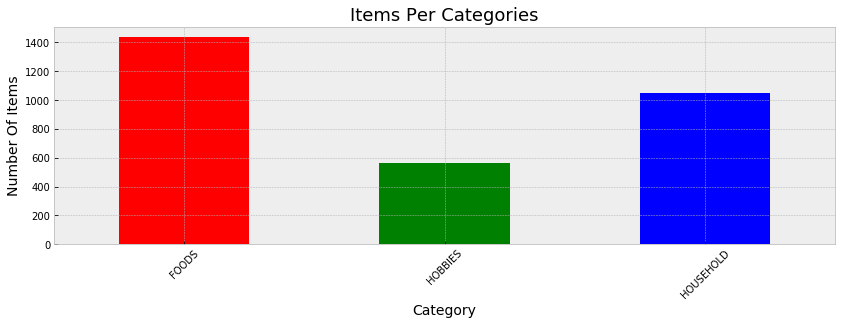

In [90]:

ax = df_sales_train.groupby(['cat_id'])['item_id'].describe()['unique'].plot(kind='bar',
                                    figsize=(14,4),
                                    color=['r', 'g', 'b', 'r', 'g', 'b', 'r'])

ax.set_title("Items Per Categories", fontsize= 18)
plt.xticks(rotation=45)
ax.set_ylabel("Number Of Items",fontsize = 14)
ax.set_xlabel("Category",fontsize=14)
plt.show()

### Items Per Department 

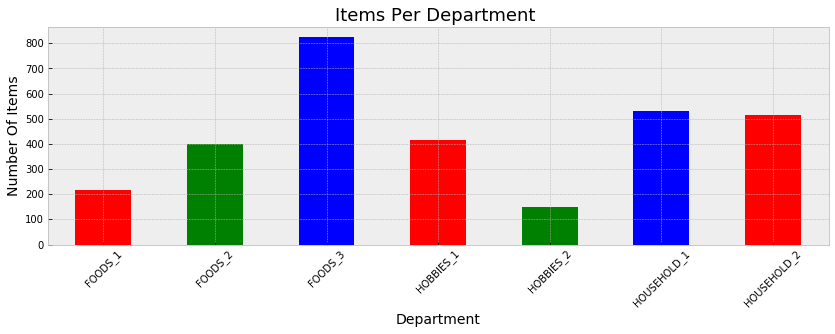

In [91]:

ax = df_sales_train.groupby(['dept_id'])['item_id'].describe()['unique'].plot(kind='bar',
                                    figsize=(14,4),
                                    color=['r', 'g', 'b', 'r', 'g', 'b', 'r'])

ax.set_title("Items Per Department ", fontsize= 18)
plt.xticks(rotation=45)
ax.set_ylabel("Number Of Items",fontsize = 14)
ax.set_xlabel("Department",fontsize=14)
plt.show()

### Time Series

Plot di una singola serie di un prodcut item ( livello più basso nella gerarchia).

Prima costruisco un dataframe adatto e poi plotto.

In [92]:
#Create date index
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [93]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
df_sales_train['item_store_id'] = df_sales_train.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = df_sales_train.loc[:,'d_1':'d_1913'].T #transpose
DF_Sales.columns = df_sales_train['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)

DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


In [94]:
DF_Sales.shape

(1913, 30490)

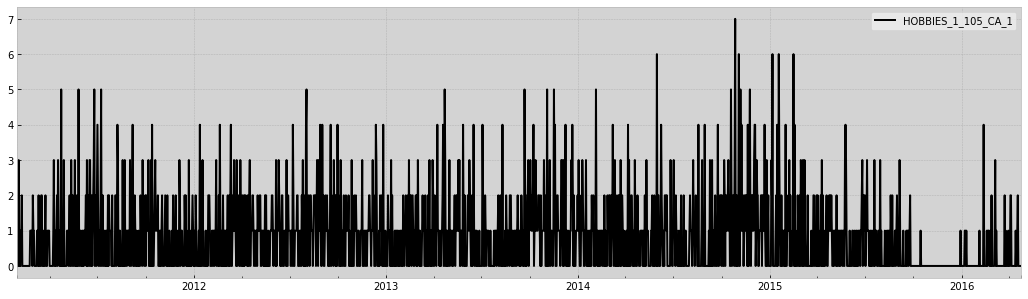

In [95]:
#plot of the first item product ind=0, plot of the last item product ind=30489
index = 100 #in this example it is plotted the 100th item product
#y = df_sales_train.loc[index,'d_1':'d_1913'].T
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
y.index = pd.to_datetime(y.index)

ax = y.plot(figsize=(18, 5),color='black')
ax.set_facecolor('lightgrey')
plt.show() 

### Aggregazione

Diversi tipi di aggregazione:



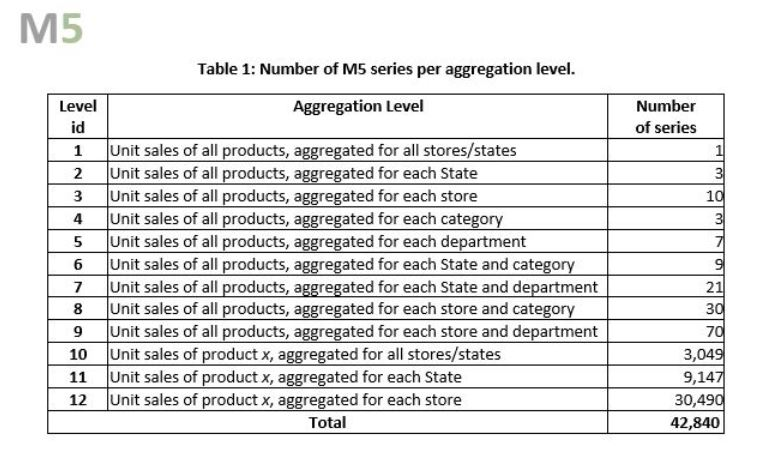

In [96]:
from IPython.display import Image
Image("../input/images/M5table.JPG")

### Aggregiation  Level 11 & 10 
* Unit sales of product x, aggregated for all stores/states
* Unit sales of product x, aggregated for each State


In [97]:

# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:', 
 
)

# Make a dropdown to select the item
item = widgets.BoundedFloatText(
    #department = Department.observe(on_value_change, names='value'),
    #minmax = Calc_Min_Max_Item(department = Department.observe(on_value_change, names='value')),
    value=0,
    min=0,
    max=1000,
    style = {'description_width': 'initial'},
    step=1,
    description='Item Numberr:',
    disabled=False,
    color='black'
)


#Notes :
#If an item out of the items range is selected - item 001 will be presented
#Seed changes will change the selection

def Plot_TS_Items_Aggr_Stata_All(Department,Item) : 

     
    Item = int(Item)
    if Item < 10:
        ItemS = '00'+str(Item)
    if Item >9 and Item < 100:
         ItemS = '0'+str(Item)
    if Item > 99 :
        ItemS = str(Item)
    if Item == None:
        ItemS = '001'
    Product =str(Department)+'_'+str(ItemS)
    
         
    
    df_product = DF_Sales.copy(deep=True)
    df_product =  df_product[df_product.columns[df_product.columns.str.contains(pat = Product)]]
    states = ['CA','TX','WI','All']
    
    
    if df_product.shape[1] == 0:
        Product =str(Department)+'_'+str('001')
        df_product =  DF_Sales[DF_Sales.columns[DF_Sales.columns.str.contains(pat = Product)]]
        

    #Aggregate All 
    df_product.loc[:,'All'] = df_product.apply(lambda x:sum(x),axis=1)

    #Aggregate across states 
    df_product.loc[:,'CA'] = df_product[df_product.columns[df_product.columns.str.contains(pat = 'CA')]].apply\
        (lambda x:sum(x),axis=1)
    df_product.loc[:,'TX'] = df_product[df_product.columns[df_product.columns.str.contains(pat = 'TX')]].apply\
        (lambda x:sum(x),axis=1)
    df_product.loc[:,'WI'] = df_product[df_product.columns[df_product.columns.str.contains(pat = 'WI')]].apply\
        (lambda x:sum(x),axis=1)



    #fig, axs = plt.subplots(1, 1, figsize=(15, 10))
    fig, axs = plt.subplots(2, 2, figsize=(14, 6))
    axs = axs.flatten()

    ax_idx = 0

    for state in states:
        ax = df_product[state].plot(title=Product+' '+state,
                                      fontsize = 14,
                                      color=next(color_cycle),
                                      ax=axs[ax_idx])
        ax_idx += 1
        ax.set_xlabel("Date",size=15)
        ax.set_ylabel("Item Sold",size = 15)
    plt.tight_layout()
    plt.show()


interactive(Plot_TS_Items_Aggr_Stata_All,Department = Department,Item = item)

interactive(children=(Dropdown(description='Select Department:', index=4, options=('HOBBIES_1', 'HOBBIES_2', '…

### Aggregiation  Level 9
* Unit sales of all products, aggregated for each store and department


In [98]:


# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:', 
 
)


def Plot_Department_Agg_By_Sate(Department):
    df_department = DF_Sales.copy(deep = True)
     
    #Create Store List 
    Stores = pd.Series(df_department.columns).apply(lambda x: x[-4:]).unique()
    df_department =  df_department[DF_Sales.columns[df_department.columns.str.contains(pat = Department)]]
    for store in Stores :
        df_department.loc[:,store] = df_department[df_department.columns[df_department.columns.str.contains(pat = store)]].apply\
            (lambda x:sum(x),axis=1)


    fig, axs = plt.subplots(5, 2, figsize=(14, 12))
    axs = axs.flatten()

    ax_idx = 0

    for store in Stores:
            ax = df_department[store].plot(title=Department+' '+store,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                          ax=axs[ax_idx])
            ax_idx += 1
            ax.set_xlabel("Date",size=15)
            ax.set_ylabel("Item Sold",size = 15)
    plt.tight_layout()
    plt.show()
    
    
interactive(Plot_Department_Agg_By_Sate,Department = Department)

interactive(children=(Dropdown(description='Select Department:', index=4, options=('HOBBIES_1', 'HOBBIES_2', '…

### Aggregiation  Level 8
* Unit sales of all products, aggregated for each store and category


In [99]:


# Make a dropdown to select the Department
Category = widgets.Dropdown(
    options= list(df_sales_train['cat_id'].unique()),
    value='FOODS',
    style = {'description_width': 'initial'},
    description='Select Department:', 
 
)


def Plot_Category_Agg_By_Sate(Category):
    df_Category = DF_Sales.copy(deep = True)
     
    #Create Store List 
    Stores = pd.Series(df_Category.columns).apply(lambda x: x[-4:]).unique()
    df_Category =  df_Category[df_Category.columns[df_Category.columns.str.contains(pat = Category)]]
    for store in Stores :
        df_Category.loc[:,store] = df_Category[df_Category.columns[df_Category.columns.str.contains(pat = store)]].apply\
            (lambda x:sum(x),axis=1)


    fig, axs = plt.subplots(5, 2, figsize=(14, 12))
    axs = axs.flatten()

    ax_idx = 0

    for store in Stores:
            ax = df_Category[store].plot(title=Category+' '+store,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                          ax=axs[ax_idx])
            ax_idx += 1
            ax.set_xlabel("Date",size=15)
            ax.set_ylabel("Item Sold",size = 15)
    plt.tight_layout()
    plt.show()
    
    
interactive(Plot_Category_Agg_By_Sate,Category = Category)

interactive(children=(Dropdown(description='Select Department:', index=2, options=('HOBBIES', 'HOUSEHOLD', 'FO…

### Aggregiation  Level 7
* Unit sales of all products, aggregated for each State and department


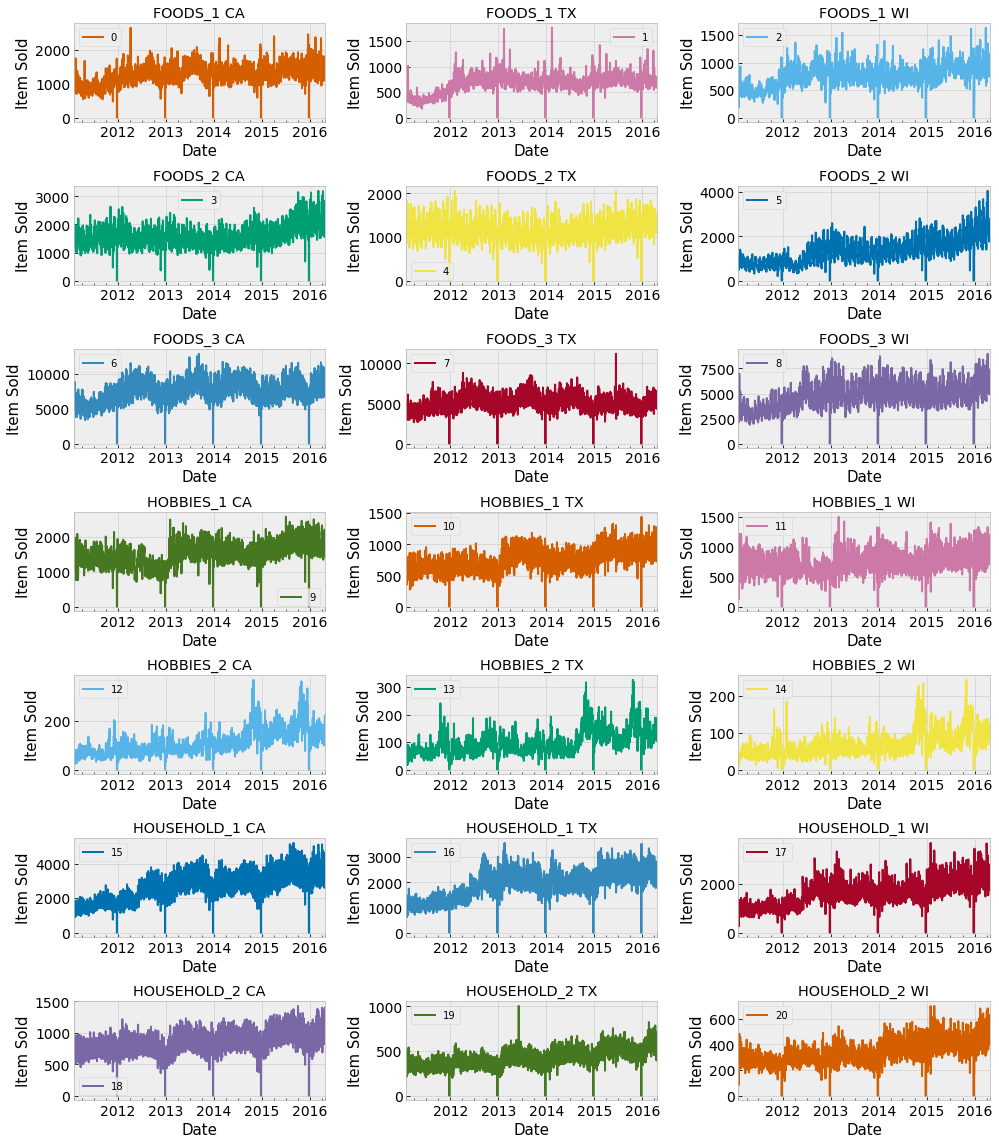

In [100]:

df_Department = DF_Sales.copy(deep = True)
     
#Create Store List 
States = ['CA','TX','WI']
Departmants = pd.Series(df_Department.columns).apply(lambda x: x[:-9]).unique()


#Create date index
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
df = df_sales_train.groupby(['dept_id','state_id'])[df_sales_train.filter(regex='d_.*').columns].sum()
df = df.reset_index()


fig, axs = plt.subplots(7, 3, figsize=(14, 16))
axs = axs.flatten()

ax_idx = 0

for index, row in df.iterrows():
    y = pd.DataFrame(row['d_1':'d_1913']).set_index([dates_list])
    y.index = pd.to_datetime(y.index)
     
    
    ax = y.plot(title=row.dept_id+' '+row.state_id,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                        ax=axs[ax_idx])
     
    ax_idx += 1
    ax.set_xlabel("Date",size=15)
    ax.set_ylabel("Item Sold",size = 15)
     
     
plt.tight_layout()
plt.show()


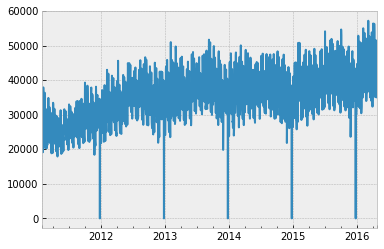

(1913,)

In [101]:
df_topLevel = DF_Sales.sum(axis=1)
df_topLevel.plot(kind = 'line')
plt.show()
df_topLevel.shape

In [102]:
#splitting dataset
TS_train=df_topLevel[:-28]
TS_test =df_topLevel[1885:]

print(TS_train.shape)
print(TS_test.shape)

(1885,)
(28,)
